In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [24]:
from tensorflow.saliency.attribution_methods import VanillaBackprop

ModuleNotFoundError: No module named 'tensorflow.saliency'

In [2]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

Using TensorFlow backend.


In [3]:
import keras
import tensorflow as tf

In [4]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
label_list = [i for i in range(10)]

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"]="0";  
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.compat.v1.Session(config=config)

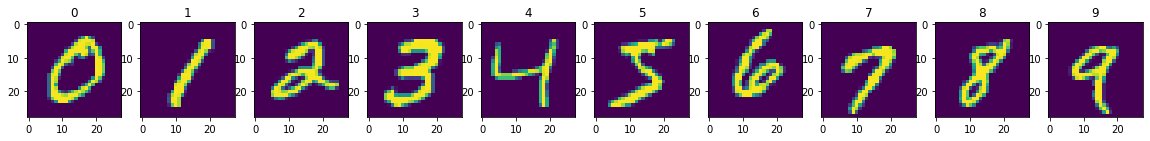

In [7]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1,10,i+1)
    coord = np.where(y_train.flatten() == i)[0][0]
    plt.imshow(x_train[coord])
    plt.title(label_list[y_train[coord]])

plt.show()

In [8]:
model = keras.models.load_model('./models/mnist_gradcam.h5')

/home/jake/venv/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 24)        240       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 14, 14, 48)        10416     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 7, 7, 48)          0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 7, 7, 64)          27712     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 3, 3, 64)          0   

In [11]:
class VisConvolution:
    def __init__(self, model, model_func, activation_layer, method='GuidedBackProp'):
        self.model = model
        self.model_func = model_func
        self.activation_layer = activation_layer

        if method == 'BackProp':
            self._register_backprop_gradient()
            self.guided_model = self._modify_graph('BackProp')
        elif method == 'DeconvNet':
            self._register_deconvnet_gradient()
            self.guided_model = self._modify_graph('DeconvNet')
        elif method == 'GuidedBackProp':
            self._register_guidedbackprop_gradient()
            self.guided_model = self._modify_graph('GuidedBackProp')
        else:
            sys.exit('method must be (BackProp, DeconvNet, GuidedBackProp)')

        self.tensor_function = self.get_tensor_function()

    # register gradient
    def _register_backprop_gradient(self):
        if "BackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("BackProp")
            def _BackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(op.inputs[0] > 0., dtype)

    def _register_deconvnet_gradient(self):
        if "DeconvNet" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("DeconvNet")
            def _DeconvNet(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype)

    def _register_guidedbackprop_gradient(self):
        if "GuidedBackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("GuidedBackProp")
            def _GuidedBackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype) * \
                       tf.cast(op.inputs[0] > 0., dtype)

    # modify model graph
    def _modify_graph(self, name):
        g = tf.get_default_graph()
        with g.gradient_override_map({'Relu': name}):

            # get layers that have an activation
            layer_dict = [layer for layer in self.model.layers[1:]
                          if hasattr(layer, 'activation')]

            # replace relu activation
            for layer in layer_dict:
                if layer.activation == keras.activations.relu:
                    layer.activation = tf.nn.relu

            # re-instanciate a new model
            K.reset_uids()
            new_model = self.model_func(weights='imagenet')
        return new_model

    # get partial tensor graph of CNN model
    def get_tensor_function(self, method='max', channel=0):
        model_input = self.guided_model.input
        layer_output = self.guided_model.get_layer(self.activation_layer).output

        if method == 'max':
            output = K.max(layer_output, axis=3)
        elif method == 'one':
            output = layer_output[:, :, :, channel]
        else:
            sys.exit('method must be (max, one)')

        tensor_function = K.function([model_input], [K.gradients(output, model_input)[0]])
        return tensor_function

    # generate saliency map(gradient)
    def generate(self, input_tensor):
        saliency = self.tensor_function([input_tensor])

        return saliency[0]


In [19]:
def _DeconvNet(model, activation_layer):
    dtype = op.inputs[0].dtype
    return grad * tf.cast(grad > 0., dtype)

In [14]:
activation_layer = 'conv2d_33'
img = x_test[0]
img_tensor = img[np.newaxis,...,np.newaxis]/255.

preds = model.predict(img_tensor)
predicted_class = preds.argmax(axis=1)[0]

In [18]:
print("preidicted top1 class:", predicted_class)
#print("predicted:", decode_predictions(preds,top=1)[0])

preidicted top1 class: 7


In [ ]:
vis_conv = VisConvolution(model,)